In [1]:
from absbox.report_parser.china import *
import toolz as tz
from lenses import lens
import dateparser
from more_itertools import transpose,unzip

In [2]:
def removePg(xs):
    return [ x for x in xs if not re.match(r"^\d+$",x)]

def removeIfAllinSet(xs:list,s:set):
    return [ x for x in xs if not set(x) == s]

In [3]:
t = '''
归集日期 期初剩余本金 回收本金 回收利息 期末剩余本金
2024/5/31 4,660,000,751.07 216,165,873.90 5,429,316.15 4,443,834,877.17
2024/6/30 4,443,834,877.17 216,102,529.82 9,718,841.41 4,227,732,347.35
2024/7/31 4,227,732,347.35 216,284,438.83 9,415,469.85 4,011,447,908.52
2024/8/31 4,011,447,908.52 216,386,135.47 9,110,984.02 3,795,061,773.05
2024/9/30 3,795,061,773.05 216,257,371.33 8,805,627.39 3,578,804,401.72
2024/10/31 3,578,804,401.72 215,955,194.69 8,500,014.86 3,362,849,207.03
2024/11/30 3,362,849,207.03 214,438,307.92 8,194,101.20 3,148,410,899.11
2024/12/31 3,148,410,899.11 206,558,597.42 7,890,064.00 2,941,852,301.69
2025/1/31 2,941,852,301.69 193,868,773.61 7,604,087.19 2,747,983,528.08
2025/2/28 2,747,983,528.08 186,505,673.82 7,346,034.99 2,561,477,854.26
2025/3/31 2,561,477,854.26 186,472,629.23 7,104,570.64 2,375,005,225.03
2025/4/30 2,375,005,225.03 186,173,640.00 6,863,133.24 2,188,831,585.03
2025/5/31 2,188,831,585.03 185,947,910.61 6,622,937.34 2,002,883,674.42
2025/6/30 2,002,883,674.42 185,473,419.27 6,383,661.54 1,817,410,255.15
2025/7/31 1,817,410,255.15 185,625,057.52 6,146,609.19 1,631,785,197.63
2025/8/31 1,631,785,197.63 185,706,884.34 5,908,201.49 1,446,078,313.29
2025/9/30 1,446,078,313.29 185,755,325.89 5,668,500.63 1,260,322,987.40
2025/10/31 1,260,322,987.40 185,821,633.73 5,427,428.08 1,074,501,353.67
2025/11/30 1,074,501,353.67 158,833,762.71 5,184,980.48 915,667,590.96
2025/12/31 915,667,590.96 132,494,776.30 4,944,924.92 783,172,814.66
2026/1/31 783,172,814.66 80,929,412.60 4,708,250.97 702,243,402.06
2026/2/28 702,243,402.06 36,122,766.76 4,483,764.74 666,120,635.30
2026/3/31 666,120,635.30 36,334,994.79 4,269,171.16 629,785,640.51
2026/4/30 629,785,640.51 36,547,485.23 4,053,236.63 593,238,155.28
2026/5/31 593,238,155.28 36,759,488.08 3,835,945.39 556,478,667.20
2026/6/30 556,478,667.20 36,950,041.82 3,617,306.67 519,528,625.38
2026/7/31 519,528,625.38 37,118,550.35 3,397,456.77 482,410,075.03
2026/8/31 482,410,075.03 37,299,564.39 3,176,587.17 445,110,510.64
2026/9/30 445,110,510.64 37,457,646.16 2,954,601.43 407,652,864.48
2026/10/31 407,652,864.48 37,637,000.32 2,731,679.03 370,015,864.16
2026/11/30 370,015,864.16 33,479,477.98 2,507,680.35 336,536,386.18
2026/12/31 336,536,386.18 29,312,600.98 2,307,714.69 307,223,785.20
2027/1/31 307,223,785.20 20,803,250.15 2,131,002.28 286,420,535.05
2027/2/28 286,420,535.05 12,840,946.15 1,998,685.41 273,579,588.90
2027/3/31 273,579,588.90 12,930,325.78 1,909,305.78 260,649,263.12
2027/4/30 260,649,263.12 13,020,335.02 1,819,296.54 247,628,928.10
2027/5/31 247,628,928.10 13,110,978.23 1,728,653.37 234,517,949.87
2027/6/30 234,517,949.87 13,195,930.52 1,637,371.14 221,322,019.35
2027/7/31 221,322,019.35 13,285,679.18 1,545,495.02 208,036,340.17
2027/8/31 208,036,340.17 13,375,829.14 1,452,984.97 194,660,511.03
2027/9/30 194,660,511.03 13,459,130.09 1,359,841.28 181,201,380.94
2027/10/31 181,201,380.94 13,542,336.73 1,266,101.19 167,659,044.21
2027/11/30 167,659,044.21 13,281,080.96 1,171,769.83 154,377,963.25
2027/12/31 154,377,963.25 12,931,866.33 1,079,156.92 141,446,096.92
2028/1/31 141,446,096.92 12,271,052.86 988,851.38 129,175,044.06
2028/2/29 129,175,044.06 11,658,789.57 903,162.07 117,516,254.49
2028/3/31 117,516,254.49 11,740,174.18 821,777.23 105,776,080.31
2028/4/30 105,776,080.31 11,820,317.46 739,817.44 93,955,762.85
2028/5/31 93,955,762.85 11,902,842.97 657,292.28 82,052,919.88
2028/6/30 82,052,919.88 11,976,634.08 574,184.28 70,076,285.80
2028/7/31 70,076,285.80 12,056,819.46 490,549.29 58,019,466.34
2028/8/31 58,019,466.34 12,141,023.57 406,345.31 45,878,442.77
2028/9/30 45,878,442.77 12,217,738.42 321,547.19 33,660,704.35
2028/10/31 33,660,704.35 12,293,388.61 236,200.66 21,367,315.74
2028/11/30 21,367,315.74 10,177,274.42 150,315.05 11,190,041.32
2028/12/31 11,190,041.32 7,656,825.13 79,077.99 3,533,216.19
2029/1/31 3,533,216.19 3,533,216.19 25,094.93 -

'''

In [4]:
## JSD
xx = tz.pipe(t
       ,lambda x: x.replace("-","0.0")
       ,removeComma
       ,lambda x: x.strip().split("\n")
       ,splitSpace
       ,lambda xs: xs[1:]
       ,lambda xs: xs & lens.Each()[0].modify(lambda y:dateparser.parse(y))
       #,lambda xs: xs & lens.Each()[0].modify(lambda y: y.strftime("%Y-%m-%d")) 
       ,lambda xs: xs & lens.Each().Fork(lens[1],lens[2],lens[3],lens[4]).modify(float)
       ,lambda xs: list(transpose(xs))
       ,lambda xs: list(transpose([xs[0],xs[4],xs[2],xs[3]]))
       ,lambda xs: xs & lens.Each().modify(list)
       )
xx

cashflowTable = tz.pipe(t
       ,lambda x: x.replace("-","0.0")
       ,removeComma
       ,lambda x: x.strip().split("\n")
       ,splitSpace
       ,lambda xs: xs[1:]
       ,lambda xs: xs & lens.Each()[0].modify(lambda y:dateparser.parse(y))
       ,lambda xs: xs & lens.Each()[0].modify(lambda y: y.strftime("%Y-%m-%d")) 
       ,lambda xs: xs & lens.Each().Fork(lens[1],lens[2],lens[3],lens[4]).modify(float)
       ,lambda xs: list(transpose(xs))
       ,lambda xs: list(transpose([xs[0],xs[4],xs[2],xs[3]]))
       ,lambda xs: xs & lens.Each().modify(list)
       )

In [18]:
## A1 s
s = \
    '''
“支付日” 目标余额(元) 还款金额(元)
2024/9/26 1,600,000,000 -
2024/10/26 1,600,000,000 -
2024/11/26 1,600,000,000 -
2024/12/26 1,408,000,000 192,000,000
2025/1/26 1,232,000,000 176,000,000
2025/2/26 1,056,000,000 176,000,000
2025/3/26 880,000,000 176,000,000
2025/4/26 704,000,000 176,000,000
2025/5/26 528,000,000 176,000,000
2025/6/26 352,000,000 176,000,000
2025/7/26 176,000,000 176,000,000
2025/8/26 - 176,000,000
    '''

In [23]:
xy = tz.pipe(s
       ,lambda x: x.replace("-","0.0")
       ,removeComma
       ,lambda x: x.strip().split("\n")
       ,splitSpace
       ,lambda xs: xs[1:]
       ,lambda xs: xs & lens.Each()[0].modify(lambda y:dateparser.parse(y))
       ,lambda xs: xs & lens.Each()[0].modify(lambda y: y.strftime("%Y-%m-%d")) 
       ,lambda xs: xs & lens.Each().Fork(lens[1],lens[2]).modify(float)
       ,lambda xs: [ _[:-1] for _ in xs]
       #,lambda xs: list(transpose(xs))
       #,lambda xs: list(transpose([xs[0],xs[4],xs[2],xs[3]]))
       #,lambda xs: xs & lens.Each().modify(list)
       )
xy

[['2024-09-26', 1600000000.0],
 ['2024-10-26', 1600000000.0],
 ['2024-11-26', 1600000000.0],
 ['2024-12-26', 1408000000.0],
 ['2025-01-26', 1232000000.0],
 ['2025-02-26', 1056000000.0],
 ['2025-03-26', 880000000.0],
 ['2025-04-26', 704000000.0],
 ['2025-05-26', 528000000.0],
 ['2025-06-26', 352000000.0],
 ['2025-07-26', 176000000.0],
 ['2025-08-26', 0.0]]

In [159]:

A1 = pd.DataFrame(data= xy).set_index(0)
A1.index.names = ['Date']
A1 = A1[[1,2]].rename(columns={1:"余额",2:"还款"})
A1["A1-利息"] = A1["余额"] * 0.02/12
A1["A1-利息"] = A1["A1-利息"].shift(periods=1,fill_value=2_666_666.667)
A1
#

,余额,还款,A1-利息
Date,,,
2024-09-26,"1,600,000,000.000",0.000,"2,666,666.667"
2024-10-26,"1,600,000,000.000",0.000,"2,666,666.667"
2024-11-26,"1,600,000,000.000",0.000,"2,666,666.667"
2024-12-26,"1,408,000,000.000","192,000,000.000","2,666,666.667"
2025-01-26,"1,232,000,000.000","176,000,000.000","2,346,666.667"
2025-02-26,"1,056,000,000.000","176,000,000.000","2,053,333.333"
2025-03-26,"880,000,000.000","176,000,000.000","1,760,000.000"
2025-04-26,"704,000,000.000","176,000,000.000","1,466,666.667"
2025-05-26,"528,000,000.000","176,000,000.000","1,173,333.333"


In [35]:
import pandas as pd
from dateutil import relativedelta
raw = pd.DataFrame(data= xx)
raw[0] = [ (_ + relativedelta.relativedelta(months=1)).replace(day=26) for _ in raw[0]]
raw = raw.set_index(0)
raw.index.names = ['Date']
poolInflow = raw[[1,2,3]].rename(columns={2:"本金",3:"利息",1:"余额"})
poolInflow["税后利息"] = poolInflow["利息"] * (1-0.0326)
poolInflow["服务费用"] = poolInflow["余额"] * 0.00025/12
poolInflow["资产池流入-合计"] = poolInflow["本金"]+poolInflow["税后利息"] - poolInflow["服务费用"]
poolInflow.head()

,余额,本金,利息,税后利息,服务费用,资产池流入-合计
Date,,,,,,
2024-06-26,4.443835e+09,2.161659e+08,5429316.15,5.252320e+06,92579.893274,2.213256e+08
2024-07-26,4.227732e+09,2.161025e+08,9718841.41,9.402007e+06,88077.757236,2.254165e+08
2024-08-26,4.011448e+09,2.162844e+08,9415469.85,9.108526e+06,83571.831428,2.253094e+08
2024-09-26,3.795062e+09,2.163861e+08,9110984.02,8.813966e+06,79063.786939,2.251210e+08
2024-10-26,3.578804e+09,2.162574e+08,8805627.39,8.518564e+06,74558.425036,2.247014e+08


In [36]:
pd.set_option('display.float_format', lambda x: f'{x:,.3f}')

In [203]:
pd.set_option('display.float_format', lambda x: f'{x:,.3f}')
jointTbl = poolInflow.join(A1[["还款","A1-利息"]]).fillna(0)#.head(16)
#计算 buffer
#jointTbl['buffer'] = jointTbl['合计'] - jointTbl['A1-本息合计']
#jointTbl.drop(columns=['利息'])

jointTbl["A2-余额"]= 0 #2460000000
jointTbl["A2-利息"]= 0 
jointTbl["A2-本金"]= 0 
jointTbl['循环购买账户'] = 0
jointTbl['可供A2本金余额'] = 0
jointTbl['可供A1本金余额'] = 0

A2Balance = 2460000000
buyAccount = 0
drawAmt = 0
cashReserve = 37_280_006.01

for index, row in jointTbl.iterrows():
    if index <= dateparser.parse("2024-08-26"):
        buyAccount += jointTbl["资产池流入-合计"].at[index]
        jointTbl['循环购买账户'].at[index] = buyAccount
        continue
        
    jointTbl["A2-余额"].at[index] = A2Balance
    jointTbl["A2-利息"].at[index] = A2Balance * 0.03 / 12
    if index <= dateparser.parse("2024-11-26"):
        buyAccount += jointTbl["资产池流入-合计"].at[index] - jointTbl["A2-利息"].at[index] - jointTbl["A1-利息"].at[index]
        jointTbl['循环购买账户'].at[index] = buyAccount
        continue
    if index == dateparser.parse("2024-12-26"):
        drawAmt = buyAccount/25
        jointTbl["资产池流入-合计"].at[index] += cashReserve
    
    jointTbl["资产池流入-合计"].at[index] += drawAmt
    if buyAccount > 0:
        buyAccount -= drawAmt
    jointTbl['循环购买账户'].at[index] = buyAccount
    
    jointTbl["可供A1本金余额"].at[index] = jointTbl["资产池流入-合计"].at[index] - jointTbl["A1-利息"].at[index] - jointTbl["A2-利息"].at[index]
    jointTbl["可供A2本金余额"].at[index] = jointTbl["可供A1本金余额"].at[index]  - jointTbl['还款'].at[index]
    jointTbl["A2-本金"].at[index] = min(jointTbl["可供A2本金余额"].at[index] ,jointTbl["A2-余额"].at[index])
    
    A2Balance -= jointTbl["A2-本金"].at[index]

jointTbl = jointTbl[["余额","本金","利息","税后利息","服务费用","资产池流入-合计","A1-利息","A2-余额","A2-利息","循环购买账户","可供A1本金余额","还款","可供A2本金余额","A2-本金"]]
jointTbl

/var/folders/pb/0lsr_g9s0x340sd74jhjdhj40000gn/T/ipykernel_24705/1965069857.py:22: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '221325614.45023564' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  jointTbl['循环购买账户'].at[index] = buyAccount
/var/folders/pb/0lsr_g9s0x340sd74jhjdhj40000gn/T/ipykernel_24705/1965069857.py:40: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '303544306.0863741' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  jointTbl["可供A1本金余额"].at[index] = jointTbl["资产池流入-合计"].at[index] - jointTbl["A1-利息"].at[index] - jointTbl["A2-利息"].at[index]
/var/folders/pb/0lsr_g9s0x340sd74jhjdhj40000gn/T/ipykernel_24705/1965069857.py:41: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '111544306.0863

,余额,本金,利息,税后利息,服务费用,资产池流入-合计,A1-利息,A2-余额,A2-利息,循环购买账户,可供A1本金余额,还款,可供A2本金余额,A2-本金
Date,,,,,,,,,,,,,,
2024-06-26,"4,443,834,877.170","216,165,873.900","5,429,316.150","5,252,320.444","92,579.893","221,325,614.450",0.000,0.000,0.000,"221,325,614.450",0.000,0.000,0.000,0.000
2024-07-26,"4,227,732,347.350","216,102,529.820","9,718,841.410","9,402,007.180","88,077.757","225,416,459.243",0.000,0.000,0.000,"446,742,073.693",0.000,0.000,0.000,0.000
2024-08-26,"4,011,447,908.520","216,284,438.830","9,415,469.850","9,108,525.533","83,571.831","225,309,392.531",0.000,0.000,0.000,"672,051,466.224",0.000,0.000,0.000,0.000
2024-09-26,"3,795,061,773.050","216,386,135.470","9,110,984.020","8,813,965.941","79,063.787","225,121,037.624","2,666,666.667","2,460,000,000.000","6,150,000.000","888,355,837.182",0.000,0.000,0.000,0.000
2024-10-26,"3,578,804,401.720","216,257,371.330","8,805,627.390","8,518,563.937","74,558.425","224,701,376.842","2,666,666.667","2,460,000,000.000","6,150,000.000","1,104,240,547.357",0.000,0.000,0.000,0.000
2024-11-26,"3,362,849,207.030","215,955,194.690","8,500,014.860","8,222,914.376","70,059.358","224,108,049.707","2,666,666.667","2,460,000,000.000","6,150,000.000","1,319,531,930.397",0.000,0.000,0.000,0.000
2024-12-26,"3,148,410,899.110","214,438,307.920","8,194,101.200","7,926,973.501","65,591.894","312,360,972.753","2,666,666.667","2,460,000,000.000","6,150,000.000","1,266,750,653.181","303,544,306.086","192,000,000.000","111,544,306.086","111,544,306.086"
2025-01-26,"2,941,852,301.690","206,558,597.420","7,890,064.000","7,632,847.914","61,288.590","266,911,433.960","2,346,666.667","2,348,455,693.914","5,871,139.235","1,213,969,375.966","258,693,628.058","176,000,000.000","82,693,628.058","82,693,628.058"
2025-02-26,"2,747,983,528.080","193,868,773.610","7,604,087.190","7,356,193.948","57,249.657","253,948,995.117","2,053,333.333","2,265,762,065.855","5,664,405.165","1,161,188,098.750","246,231,256.619","176,000,000.000","70,231,256.619","70,231,256.619"


In [204]:
p = jointTbl[["可供A1本金余额","还款"]][dateparser.parse("2024-12-26"):dateparser.parse("2025-08-26")]
p["Excess Pct"] = (p["可供A1本金余额"] - p["还款"])/p["还款"]
p

,可供A1本金余额,还款,Excess Pct
Date,,,
2024-12-26,"303,544,306.086","192,000,000.000",0.581
2025-01-26,"258,693,628.058","176,000,000.000",0.470
2025-02-26,"246,231,256.619","176,000,000.000",0.399
2025-03-26,"239,091,314.140","176,000,000.000",0.358
2025-04-26,"239,279,623.403","176,000,000.000",0.360
2025-05-26,"239,202,478.642","176,000,000.000",0.359
2025-06-26,"239,199,597.183","176,000,000.000",0.359
2025-07-26,"238,948,826.790","176,000,000.000",0.358
2025-08-26,"239,325,713.185","176,000,000.000",0.360


In [205]:
A2Flow

,A2-余额
2024-12-26,"2,460,000,000.000"
2025-01-26,"2,348,881,235.593"
2025-02-26,"2,266,592,696.547"
2025-03-26,"2,196,747,347.000"
2025-04-26,"2,134,023,477.024"
2025-05-26,"2,071,092,792.164"
2025-06-26,"2,008,220,731.324"
2025-07-26,"1,945,333,008.414"
2025-08-26,"1,882,677,515.434"
2025-09-26,"1,819,626,533.450"


<Axes: >

/opt/homebrew/lib/python3.11/site-packages/IPython/core/events.py:89: UserWarning: Glyph 20313 (\N{CJK UNIFIED IDEOGRAPH-4F59}) missing from current font.
  func(*args, **kwargs)
/opt/homebrew/lib/python3.11/site-packages/IPython/core/events.py:89: UserWarning: Glyph 39069 (\N{CJK UNIFIED IDEOGRAPH-989D}) missing from current font.
  func(*args, **kwargs)
/opt/homebrew/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 20313 (\N{CJK UNIFIED IDEOGRAPH-4F59}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/homebrew/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 39069 (\N{CJK UNIFIED IDEOGRAPH-989D}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


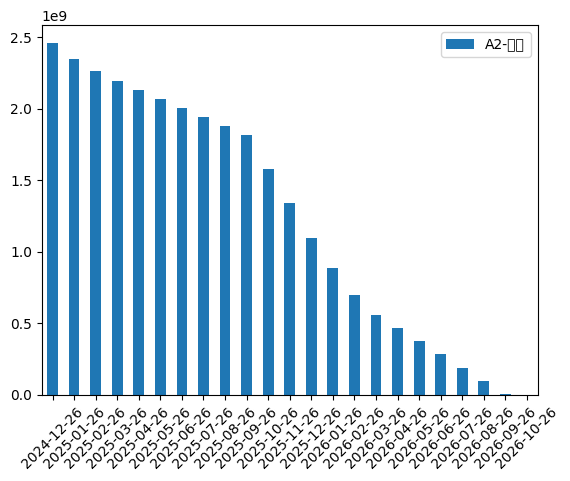

In [206]:
A2Flow = jointTbl[['A2-余额']][dateparser.parse("2024-12-26"):dateparser.parse("2026-10-26")]
A2Flow.index = A2Flow.index.date
A2Flow.plot.bar( rot=45)

In [215]:
import sys
sys.path.insert(0, r"/Users/xiaoyu/Projects/PyABS")

In [38]:
# JSD 2024-3
from absbox import SPV

JSD_AUTO_2024_2 = SPV(
    "吉时代2024年第二期个人汽车抵押贷款资产支持证券"
    ,{"封包日":"2024-04-30","起息日":"2024-08-09","首次兑付日":"2024-09-26"
     ,"法定到期日":"2031-07-26","收款频率":"月末","付款频率":["每月",26]} 
    ,{'发行':{'资产池规模':4_660_001_751.07}
      ,'清单':[]
      ,'归集表':cashflowTable}
    ,(("信托收付账户",{"余额":0 })
      ,("流动性储备",{"余额":37_280_006.01
                    ,"类型":{"when":[["status","循环"]
                                   ,{"目标储备金额":[("originalPoolBalance",),0.008]}
                                   ,{"目标储备金额":[["合计"
                                                   ,("债券当期已付利息","优先A1","优先A2")
                                                    ,("已付费用",'服务商费用')
                                                    ,("债券待付利息","优先A1","优先A2")
                                                    ,("待付费用",'服务商费用')
                                                   ]
                                                  , 3.0]}]}}))
    ,(("优先A1",{"当前余额":1_600_000_000.00
             ,"当前利率":0.0207
             ,"初始余额":1_600_000_000.00
             ,"初始利率":0.0207
             ,"起息日":"2024-08-09"
             ,"初始利率":0.0207
             ,"利率":{"固定":0.0207}
             ,"债券类型":{"固定摊还":[['2024-09-26', 1600000000.0],
                                 ['2024-10-26', 1600000000.0],
                                 ['2024-11-26', 1600000000.0],
                                 ['2024-12-26', 1408000000.0],
                                 ['2025-01-26', 1232000000.0],
                                 ['2025-02-26', 1056000000.0],
                                 ['2025-03-26', 880000000.0],
                                 ['2025-04-26', 704000000.0],
                                 ['2025-05-26', 528000000.0],
                                 ['2025-06-26', 352000000.0],
                                 ['2025-07-26', 176000000.0],
                                 ['2025-08-26', 0.0]]
                     }
             })
      ,("优先A2",{"当前余额":2_460_000_000.00
             ,"当前利率":0.03
             ,"初始余额":2_460_000_000.00
             ,"初始利率":0.03
             ,"起息日":"2024-08-09"
             ,"初始利率":0.03
             ,"利率":{"固定":0.03}
             ,"债券类型":{"过手摊还":None}
             })
      ,("次级",{"当前余额":600_000_751.07
             ,"当前利率":0.0
             ,"初始余额":600_000_751.07
             ,"起息日":"2024-08-09"
             ,"利率":{"固定":0.00}
             ,"初始利率":0.0
             ,"债券类型":{"权益":None}
             })
     )
    ,(("增值税",{"类型":{"差额费用":[("*"
                                   ,("资产池累计",None,"利息"),0.0326)
                                   ,("费用支付总额",None,"增值税")]}})
      ,("服务商费用",{"类型":{"年化费率":[("资产池余额",),0.00025]}}),
      #,("报销",{"类型":{"周期费用":["每月",60000]}})
     )
    ,{"摊销":[
         ["账户转移","流动性储备","信托收付账户"]
         ,["支付费用","信托收付账户",["增值税"]] 
         #,["支付费用限额",["收入分账户"],["报销"],{"应计费用上限":50000}]
         ,["支付费用","信托收付账户",["服务商费用"]]
         ,["计提支付利息","信托收付账户",["优先A1","优先A2"]]
         ,["账户转移","信托收付账户","流动性储备",{"储备":"缺口"}]
         
         ,["顺序支付本金","信托收付账户",["优先A1","优先A2"]]
          #,["支付费用限额",["收入分账户"],["报销"]]
         ,["支付本金","信托收付账户",["次级"]]
         ,["支付收益","信托收付账户","次级"]
      ]
     ,"循环":[
         ["账户转移","流动性储备","信托收付账户"]
         ,["支付费用","信托收付账户",["增值税"]] 
         #,["支付费用限额",["收入分账户"],["报销"],{"应计费用上限":50000}]
         ,["支付费用","信托收付账户",["服务商费用"]]
         ,["计提支付利息","信托收付账户",["优先A1","优先A2"]]
         ,["账户转移","信托收付账户","流动性储备",{"储备":"缺口"}]
         
          #,["支付费用限额",["收入分账户"],["报销"]]
         
         ,["购买资产",["Current|Defaulted",1.0,0],"信托收付账户",None]
     ]
     ,"回款后":[["计提费用","服务商费用","增值税"]]
     ,"清仓回购":[
                 ["出售资产",["正常|违约",1.0,0.0],"信托收付账户"]
                 ,["账户转移","流动性储备","信托收付账户"]
                 ,["支付费用","信托收付账户",["增值税"]] 
                 ,["支付费用","信托收付账户",["服务商费用"]]
                ,["计提支付利息","信托收付账户",["优先A1","优先A2"]]
                ,["支付本金","信托收付账户",["优先A1","优先A2"]]
                ,["支付本金","信托收付账户",["次级"]]
                ,["支付收益","信托收付账户","次级"]
             ]
     }
    ,(["利息回款","信托收付账户"]
      ,["本金回款","信托收付账户"]
      ,["早偿回款","信托收付账户"]
      ,["回收回款","信托收付账户"])
    ,None
    ,None
    ,None
    ,{"回收后":{
           "进入摊还期":{"condition":["any"
                                      ,[">=","2024-11-30"]
                                      ,[("cumPoolDefaultedRate",),">",0.015]
                                    ]
             ,"effects":("newStatus","摊还")
             ,"status":False
             ,"curable":False}}}
    ,("设计","循环")
)

In [39]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
from absbox import API,EnginePath


localAPI = API(EnginePath.DEV,check=False,lang='english')

myAssumption = ("Pool",("Mortgage",None,{"CPR":0.00},None,None)
                                ,None
                                ,None)

revol_asset = ["Mortgage"
                ,{"originBalance":100,"originRate":["fix",0.023],"originTerm":36
                  ,"freq":"Monthly","type":"Level","originDate":"2021-07-01"}
                  ,{"currentBalance":100
                  ,"currentRate":0.023
                  ,"remainTerm":25
                  ,"status":"current"}]

r = localAPI.run(JSD_AUTO_2024_2
                ,poolAssump=myAssumption
                 ,runAssump=[("revolving"
                                ,["constant",revol_asset]
                                ,("Pool",("Mortgage",None,None,None,None)
                                          ,None
                                          ,None))
                            ,("pricing",{"date":"2024-04-09"
                                       ,"curve":[["2024-04-09",0.03]]})
                            ,("call",{"poolFactor":0.10})
                            ]
                ,read=True)

Connecting engine server -> https://absbox.org/api/dev

✅Connected, local lib:0.28.7, server:0.28.16

Warning Message from server:

In [41]:
r['pricing']['summary']

,估值,票面估值,WAL,久期,凸性,应计利息
优先A1,"1,574,388,338.110",98.399,1.040,0.920,2.040,0
优先A2,"2,437,029,935.360",99.066,1.600,1.240,4.010,0
次级,"671,931,623.380",111.988,2.570,2.550,8.750,0


In [42]:
r['pricing']['breakdown']['优先A1']

,balance,interest,principal,rate,cash,intDue,intOverInt,factor,memo
date,,,,,,,,,
2024-09-26,1600000000,"4,355,506.840",0,0.021,"4,355,506.840",0,0,1.000,<PayInt:优先A1>
2024-10-26,1600000000,"2,722,191.780",0,0.021,"2,722,191.780",0,0,1.000,<PayInt:优先A1>
2024-11-26,1600000000,"2,812,931.500",0,0.021,"2,812,931.500",0,0,1.000,<PayInt:优先A1>
2024-12-26,1408000000,"2,722,191.780",192000000,0.021,"194,722,191.780",0,0,0.880,"[<PayInt:优先A1>, <PayPrin:优先A1>]"
2025-01-26,1232000000,"2,475,379.720",176000000,0.021,"178,475,379.720",0,0,0.770,"[<PayInt:优先A1>, <PayPrin:优先A1>]"
2025-02-26,1056000000,"2,165,957.260",176000000,0.021,"178,165,957.260",0,0,0.660,"[<PayInt:优先A1>, <PayPrin:优先A1>]"
2025-03-26,880000000,"1,676,870.130",176000000,0.021,"177,676,870.130",0,0,0.550,"[<PayInt:优先A1>, <PayPrin:优先A1>]"
2025-04-26,704000000,"1,547,112.320",176000000,0.021,"177,547,112.320",0,0,0.440,"[<PayInt:优先A1>, <PayPrin:优先A1>]"
2025-05-26,528000000,"1,197,764.380",176000000,0.021,"177,197,764.380",0,0,0.330,"[<PayInt:优先A1>, <PayPrin:优先A1>]"
